# TODO
 - make seasonnal function (juste pour le bo geste)
 - validation pour choisir juste la meilleur category et pas les n'th meilleures
 - sortir les id de category et pas le y0 avec la correlation
 - faire corelation solo
 - nettoyer le code pour improvement overall
 - nettoyer le code pour improvement shift
 
 
 
# ToC

 - 0. Importing librairies
 
 - 1. Preprocessing all the data
    - 1.1. Birth data
    - 1.2. Google Trend Data
        - 1.2.1. Find all Google Trend Data categories
        - 1.2.2. Extracting all Google Trend Data for each categories
        
- 2. Category Selection
    - 2.0. Mini preprocessing
    - 2.0.0. Rolling window validation
    - 2.1. By correlation overall
        - 2.1.1. Algorithm
        - 2.1.2. Parameter validation
        - 2.1.3. Run
    - 2.2. By correlation with rolling window
        - 2.2.1. Algorithm
        - 2.2.2. Parameter validation
        - 2.2.3. Run
    - 2.3. By improvement overall
        - 2.3.1. Algorithm
        - 2.3.2. Parameter validation
        - 2.3.3. Run
    - 2.4. By improvement with rolling window
        - 2.4.1. Algorithm
        - 2.4.2. Parameter validation
            - 2.4.2.1. Months shifting
            - 2.4.2.2. Number of best category
        - 2.4.3. Run
    - 2.5. Final Algorithm selection
        - 2.5.1. Selection
        - 2.5.2. Final category selection
    
    
- 3. Prediction and visualization
    - 3.1. Prediction
    - 3.2. Prediction plotting
    - 3.3. Visualisation of categories

# 0. Importing librairies

In [3]:
# Importing librairies
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from dateutil.relativedelta import relativedelta
from statsmodels.regression.rolling import RollingOLS

# External librairies
# Google trend unofficial API
#from pytrends.request import TrendReq

# 1. Preprocessing all the data
## 1.1 Birth data

In [4]:
# Folder with all the csv to export/import
data_folder = './Data/'

# Importing birth data with selecting correct columns and changing columns names
birth_df = pd.read_csv(data_folder +'valeurs_mensuelles.csv', sep= ';', index_col= 0, skiprows=2, usecols=[0,1],header=0, names=['Période','birth'])

# Changing indexes to panda date
birth_df.index = pd.to_datetime(birth_df.index)

# Putting sales data in log scale as we want
birth_df['birth'] = birth_df['birth'].apply(np.log)

# Getting an overview
birth_df = birth_df.sort_index()
birth_df

,birth
Période,
2004-01-01,11.067248
2004-02-01,10.989048
2004-03-01,11.018383
2004-04-01,11.020529
2004-05-01,11.026028
...,...
2020-06-01,10.978490
2020-07-01,11.044521
2020-08-01,11.008744


## 1.2 Google Trend Data
### 1.2.1 Find all Google Trend Data categories

In [1]:
# Function definition we will use later for extracting data contained in a nested dictionaries with lists.
def extract(dict_in, list_out, list_out2,list_out3 ,list_out4 , parent,i,MinLevel):
    '''
    Recursive function extracting data contained in a nested dictionaries with lists.
    It extract:
     - all integers
     - entry with key 'name'
     - the level (parent/children) of the nested dictionary
     - the parent name of the previous dictionary
     
    The code was adapted from here : https://stackoverflow.com/questions/10569636/how-to-get-all-keysvalues-in-nested-dict-of-list-of-dicts-and-dicts/10569687
    
    INPUT:
        - dict_in: dictionary you want to extract from
        - list_out(1-4): list containing all information found by previous recursion (more details in OUTPUT)
        - parent:  name of last entry with key 'name' and level equal to Minlevel found by previous recursion
        - i: level of previous recursive function
        - Min level: Level at where we want to keep track of parent dictionary
        
    OUTPUT:
        - list_out: list containing all integers entry in dict_in
        - list_out2: list containing all entry entry with key 'name' in dict_in
        - list_out3: list containing all levels of dict_in
        - list_out4: list containing all parent name of dict_in
        - parent: name of last entry with key 'name' and level equal to Minlevel
        - i: level of current recursive function
    '''
    i=i+1                                             # Add one level to recursive function

                                                      # Reverse the dictionary order
    rdict_in = dict()                                 # Prepare a new  dictionary
    for k in reversed(dict_in):                       # For each entry in reversed ordered dictionary
        rdict_in[k] = dict_in[k]                          # Save it in new dictionary
    
    for key, value in rdict_in.items():               # for all entry in reversed dict_in
        if isinstance(value, dict):                       # If value itself is dictionary
            extract(value,
                    list_out, list_out2,
                    list_out3, list_out4,
                    parent, i,MinLevel)                       # Then do recursion and input this dictionary in dict_in
        elif isinstance(value, list):                     # Else if this value is a list
            for key2 in value:                                 # Then for each entry in this list
                extract(key2,
                        list_out, list_out2,
                        list_out3,list_out4,
                        parent,i,MinLevel)                         # Do recursion and input this entry in dict_in
        elif isinstance(value, int):                      # Else if this value is an integer
            list_out.append(value)                             # Add the value to list_out
        elif key=='name':                                 # Else if this value has key == 'name'
            list_out2.append(value)                            # Add this value to list_out2
            list_out3.append(i)                                # Add the level of this value in list_out3
            if i==MinLevel:                                    # If current level is equal to the level we want to keep track of
                parent = value                                     # Then add current value to the parent variable
                list_out4.append('nul')                            # Add the value 'nul' as parent of current value
            else:                                              # Else
                list_out4.append(parent)                           # Add the last parent as parent of current value
    return list_out,list_out2,list_out3,list_out4 , parent ,i # Return the two list to have valid recursion


In [ ]:
# Create a trend rquest object with language, timzone offset, number of retry if request fail, time factor to make each retry (wait 0.1s , 0.2s, 0.3s, ...)
pytrends = TrendReq(hl='US-US',tz=60, retries=10,backoff_factor=0.1,)

# Extract all google trend categories in a nested dictionary
categories_dictionary = pytrends.categories()

# Initailaze list for extracting data
categories_ids =[]
categories_names = []
level=[]
parent =[]
# Initialise level, and name for categories with no parents
i=0
init='nul'
# Selecting the level of categroies we want to keep as parent
MinLevel = 2
# Extracting the Categories in the nested dictionary using recursive function
[categories_ids,categories_names,level,parent,init,i] = extract(categories_dictionary,categories_ids,categories_names,level,parent , init,i,MinLevel)

# making a dataframe and drooping duplicates categories (ex: category Programmation id: 31 is a sub category of 'Computer Hardware' and 'Computer science')
categories_df = pd.DataFrame(zip(categories_ids,categories_names,level,parent),columns=['id','name','level','parent']).sort_values(['id','level'])
categories_df=categories_df.drop_duplicates(subset ="id")

# saving to a csv a getting an overview
categories_df.to_csv(data_folder + 'categories.csv')
categories_df

### 1.2.2 Extracting all Google Trend Data for each categories

In [ ]:
# Initializing a dataframe for Google Trend Data
GTD_df = pd.DataFrame()
# for each categories
for j,i in enumerate(categories_df['id']):
    # build request payload empty key word with france geolocation with the i'th category from 2004-01-01 to 2020-12-31
    kw_list = [""]
    pytrends.build_payload(kw_list, geo='FR', cat=i , timeframe='2004-01-01 2020-12-31')
    
    # getting google trend data
    temp = pytrends.interest_over_time()
    
    # if the return is not empty save data (may happen for small categories with not enough data the return is empty
    # Ex : category 42 "jazz" https://trends.google.com/trends/explore?cat=42&date=all&geo=FR)
    if not temp.empty:
        GTD_df[i]=temp.iloc[:,0]   
    
# getting an overview    
GTD_df

An error is araising because pytrend is not unofficial pseudo API for google trend. Therefore some error are raising and they are not solved yet.<br>
As we can read here: https://github.com/GeneralMills/pytrends/issues/413, the error 429 we are obtaining now is often a "Too many request" code but this error is arraising for random number of requests and has no definite solution.<br>
Therefore, we made the preprocessing in another notebook by running it multiple time and made a full dataframe containing all the request that we will import in the next cells.

In [5]:
# Importing google trend data preprocessed exactly the same in another notebook
GTD_df = pd.read_csv(data_folder +'GTD.csv',index_col= 0)
GTD_df.index = pd.to_datetime(GTD_df.index)
GTD_df

,0,3,5,7,8,11,12,13,14,16,...,1381,1385,1386,1387,1388,1389,1390,1391,1392,1397
date,,,,,,,,,,,,,,,,,,,,,
2004-01-01,100,53,89,54,46,50,74,60,78,43,...,4,67,41,19,29,30,58,84,73,31
2004-02-01,75,53,84,55,46,47,74,55,72,40,...,4,100,52,38,72,60,85,81,92,26
2004-03-01,68,55,85,62,45,50,77,59,77,45,...,2,51,51,21,66,37,39,82,71,26
2004-04-01,56,56,85,59,48,54,78,55,76,43,...,3,88,89,33,76,75,56,78,98,26
2004-05-01,75,56,86,50,47,54,75,59,76,45,...,3,14,51,23,45,59,100,70,78,36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-01,44,33,18,53,24,81,54,25,55,58,...,31,9,12,9,23,34,79,50,20,9
2020-09-01,48,32,20,61,23,74,60,28,58,53,...,31,14,24,9,32,24,76,42,11,9
2020-10-01,52,33,21,62,25,80,63,28,61,55,...,34,11,19,11,33,18,78,43,9,10


# 2. Category Selection

## 2.0. Mini preprocessing

In [3]:
#Function to standardize data
def standardize(data):
    mean_x = np.mean(data)
    std_x = np.std(data)
    x = data
    x = x - mean_x
    for i in range (len(std_x)):
        if std_x[i] == 0:
            std_x[i]=1
    x = x / std_x
    return x

In [7]:
# Make columns name to numeric
col = pd.to_numeric(GTD_df.columns)

# Keeping only the elements of interest and getting an overview
categories_df = categories_df[categories_df['id'].isin(col)]

# standardize the Google Trend Data
GTD_df = standardize(GTD_df)

# Remove seasonnality 
# Make function

# Shifting columns to make Auto Regressive model
nan = np.empty(6)
nan[:] = 0
birth_df['birth_6'] =  [*nan , *birth_df.birth[:-6].values] # Moving down 6 rows and putting 0 in the empty space
nan = np.empty(12)
nan[:] = 0
birth_df['birth_12'] =  [*nan , *birth_df.birth[:-12].values] # Moving down 12 rows and putting 0 in the empty space

NameError: name 'categories_df' is not defined

## 2.0.0. Rolling window validation

Validation de la roling window sur le base model

In [8]:
def prediction_bestK(k,data,start ='2004-01-01',end ='2020-11-01'):
    '''
    For a list of rolling window size, find the mae of the base model
    
    Input:
        -start/end: start and end date of data
        -k : list of possible rolling window
        -data: the data we want to predict on
        
    Ouput:
        -MAES: an array containing the MAE of each k
    '''
    
    # Creating list four saving data
    MAES = []
    # For each rolling window
    for i in k:
        # Creating new df and selcting correct date
        df = data.copy()
        df = df.loc[start:end]
        # Saving the index for later plotting
        index_date = df.index
        df = df.reset_index(drop=True) #Resetting the index to [0-n] format
        
        # Prediction with base model
        res_base = RollingOLS.from_formula('birth ~ birth_6 + birth_12', data=df, window=i).fit() #We use our rolling windows function
        params = pd.DataFrame(res_base.params.shift(periods=1, axis=0)) #we shift the output parameters one row down in order to apply to the next mont (predict)
        params.columns = ['a0','a1','a2'] #Changing the parameters' columns names
        df = pd.concat([df, params], axis=1) #adding it to our dataframe
        df['predict_base'] = df.a0 + df.a1*df.birth_6 + df.a2*df.birth_12 #predicting the values for the next month
         
        # add correct date index again
        df.index = index_date
    
        #MAE calculation and saving it to list
        mae_base = np.mean(abs(df.birth-df.predict_base))*100
        MAES.append(mae_base)
        
    return MAES


In [9]:
# Creating a list of possible rolling window size
k = list(range(19,26))

# Copying dataframe to not overwrite
df = birth_df.copy()

# Find the best K and output it in nice Dataframe
MAES = prediction_bestK(k,df)
MAES = pd.DataFrame([MAES],columns=[['MAE Base k = %d' % x for x in k] ])

MAES

,MAE Base k = 19,MAE Base k = 20,MAE Base k = 21,MAE Base k = 22,MAE Base k = 23,MAE Base k = 24,MAE Base k = 25
0,1.976743,1.928902,1.939169,1.883182,1.88641,1.85148,1.887508


In [10]:
# Selecting the best rolling window k
k = list(range(19,26))
t= MAES.values.argmin()
k = k[t]
k

24

### 2.0.1 prediction and Plotting function

In [20]:
def prediction(start,end,k,data,GTD,ids):
    df = data.copy()
    temp_GTD = GTD.copy()
    df = df.loc[start:end]
    temp_GTD = temp_GTD.loc[str(start-pd.DateOffset(months=1)):str(end)]
        
    #Features selection
    formula = str('birth ~ birth_6 + birth_12')
    columns_name = ['b0','b1','b2']
    for j,i in enumerate(ids):
        df["y%d"%j] = temp_GTD.loc[:,str(int(i))]
        formula = formula + ' + ' + str("y%d"%j)
        columns_name.append(str("b%d"%(j+ 3)))
        #GTD_df.loc[:,str(categories_best.id[i])]

    index_date = df.index #saving the index for later plotting
    df = df.reset_index(drop=True) #Resetting the index to [0-n] format


    res_base = RollingOLS.from_formula('birth ~ birth_6 + birth_12', data=df, window=k).fit() #We use our rolling windows function
    params = pd.DataFrame(res_base.params.shift(periods=1, axis=0)) #we shift the output parameters one row down in order to apply to the next mont (predict)
    params.columns = ['a0','a1','a2'] #Changing the parameters' columns names
    df = pd.concat([df, params], axis=1) #adding it to our dataframe
    df['predict_base'] = df.a0 + df.a1*df.birth_6 + df.a2*df.birth_12 #predicting the values for the next month

    res_trend = RollingOLS.from_formula(formula, data=df, window=k).fit()#We use our rolling windows function
    params = pd.DataFrame(res_trend.params.shift(periods=1, axis=0)) #we shift the output parameters one row down in order to apply to the next mont (predict)
    params.columns = columns_name#Changing the parameters' columns names
    df = pd.concat([df, params], axis=1) #adding it to our dataframe
    df['predict_trend'] = df.b0 + df.b1*df.birth_6 + df.b2*df.birth_12 
    for j,i in enumerate(ids):
        df['predict_trend'] = df['predict_trend'] + params.iloc[:,3+j]*  df.iloc[:,3+j]  #predicting the values for the next month


    #add date index again
    df.index = index_date
    return df




#Function to show the plot from paper
def showPlot(df, improvement_overall):
    '''
    df: DataFrame with all the parameters to plot (birth; predict_base; predict_trend)
    improvement_overall: value of the improvement
    '''
    
    #Defining the overall parameters for the figure
    params = {'legend.fontsize': 20,
              'legend.handlelength': 3,
              'figure.figsize': (15,10),
              'axes.labelsize' : 15,
              'xtick.labelsize' : 15,
              'ytick.labelsize' : 15}
    plt.rcParams.update(params) #applying them

    #plotting each curve with specific parameters
    fig, ax = plt.subplots()
    ax.plot(df.birth, 'k', linewidth=2, label='Actual') #Thicker line for the real data
    ax.plot(df.predict_base, 'k--', linewidth=1,label='Base') #Doted line for the predicted curve with basic data
    ax.plot(df.predict_trend, 'k', linewidth=1, label='Trends') #Classic line for the predicted curve with basic + trend data

    #Defining figure title
    plt.suptitle('Births in France', fontsize=20)

    #Defining (x;y) labels
    plt.xlabel('Index')
    plt.ylabel('log(mvp)')

    #Plotting the legend
    plt.legend(loc="upper right")

    #Creating the box with the MAE improvements
    textstr = '\n'.join((
        r'MAE improvement',
        r'Overall = $%.1f$%%' % (improvement_overall, )))
    ax.text(0.013, 0.135, textstr, transform=ax.transAxes, fontsize=17.5,
            verticalalignment='top', bbox=dict(facecolor='none', edgecolor='black', pad=10))

    #Showing the plot
    plt.show
    return

## 2.1. By correlation overall

### 2.1.1. Algorithm

In [89]:
# Importing birth data with selecting correct columns and changing columns names
#######################
#### TO DELETE ########
#######################
#####OLD WORKSPACE#####
#######################

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.formula.api as smf
from statsmodels.regression.rolling import RollingOLS
from dateutil.relativedelta import relativedelta
from datetime import datetime
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from numpy import linalg as LA

data_folder = './Data/'
birth_df = pd.read_csv(data_folder +'valeurs_mensuelles.csv', sep= ';', index_col= 0, skiprows=2, usecols=[0,1],header=0, names=['Période','birth'])

# Changing indexes to panda date
birth_df.index = pd.to_datetime(birth_df.index)

# Putting sales data in log scale as we want
birth_df['birth'] = birth_df['birth'].apply(np.log)

# Getting an overview
birth_df = birth_df.sort_index()

GTD_df = pd.read_csv(data_folder +'GTD.csv',index_col= 0)
GTD_df.head(10)

# Getting an overview
GTD_df = GTD_df.loc['2004-01-01':'2020-10-01']
col = pd.to_numeric(GTD_df.columns)
GTD_df = standardize(GTD_df)

# Importing google trend categories
categories_df = pd.read_csv(data_folder +'categories.csv',index_col= 0)

# Keeping only the elements of interest and getting an overview
categories_df = categories_df[categories_df['id'].isin(col)]


nan = np.empty(6)
nan[:] = 0
birth_df['birth_6'] =  [*nan , *birth_df.birth[:-6].values] # Moving down 6 rows and putting 0 in the empty space
nan = np.empty(12)
nan[:] = 0
birth_df['birth_12'] =  [*nan , *birth_df.birth[:-12].values] # Moving down 12 rows and putting 0 in the empty space 

In [94]:
#function definition

#10 best features selection based on its correlation with the birth number
def bestFeatureCorrelation(date, k):
    '''
    date: date at which we want to determine the correlation
    k: size of the data we want to check the correlation on (size recommended: identical to the ORLS)
    '''    
    
    #Number of month in which we should look for correlation before choosing the best (size of the rolling ols)
    pearson = [] #df in which we store the pearson correlation factor
    kendall = [] #df in which we store the kendall correlation factor
    spearman = [] #df in which we store the spearman correlation factor
    
    end_date = datetime.strptime(date, '%Y-%m-%d')  
    start_date = end_date - relativedelta(months=+k)

    end_date = datetime.strftime(end_date, '%Y-%m-%d')
    start_date = datetime.strftime(start_date, '%Y-%m-%d')

    temp_df=pd.DataFrame(GTD_df.loc[start_date:end_date], dtype='float') #Taking the time index that are also in the birth_df
    birth_temp = pd.DataFrame(birth_df.loc[start_date:end_date], dtype='float')
    for i,j in enumerate(categories_df['id']):

        if str(j) in temp_df.columns:
            #Pearson correlation calculation
            pearsonTemp = np.abs(birth_temp.iloc[:,0].corr(temp_df[str(j)],method='pearson'))
            pearson.append(pearsonTemp)
            #Kendall correlation calculation
            kendallTemp = np.abs(birth_temp.iloc[:,0].corr(temp_df[str(j)],method='kendall'))       
            kendall.append(kendallTemp)
            #Spearman correlation calculation
            spearmanTemp = np.abs(birth_temp.iloc[:,0].corr(temp_df[str(j)],method='spearman'))
            spearman.append(spearmanTemp)

        else:
            #if the correlation could not be calculated -> put NaN
            pearson.append(np.nan)
            kendall.append(np.nan)
            spearman.append(np.nan)

    #Normalizing our correlation indicators in order to combine them and compare them
    pearsonNorm = 100 / np.nanmax(pearson)
    categories_df['Pearson'] = np.multiply(pearsonNorm, pearson)
    kendallNorm = 100 / np.nanmax(kendall)    
    categories_df['Kendall'] = np.multiply(kendallNorm, kendall)
    spearmanNorm = 100 / np.nanmax(spearman)
    categories_df['Spearman'] = np.multiply(spearmanNorm, spearman)

    #Crossing between our correlations to see which feature is the best
    cal = pd.DataFrame([categories_df["Spearman"], categories_df["Pearson"], categories_df["Kendall"]]).transpose()
    cal = cal.mean(axis=1)
    categories_df['Mean'] = cal

    #Displaying the 10 best
    categories_best = categories_df.sort_values('Mean', ascending=False).iloc[0:100,:].reset_index(drop=True)
    return  categories_best

def predictionCorr(date,k,birth_df,GTD,ids):
    '''
    date: dates at which we want to predict
    k: size of the rolling windows
    df: birth df
    temp_GTD: Google Trends DF
    ids.: ids of category
    '''
    
    df = birth_df.copy()
    temp_GTD = GTD_df.copy()
    
    end = datetime.strptime(date, '%Y-%m-%d')  
    start = end - relativedelta(months=+k)
    end = datetime.strftime(end, '%Y-%m-%d')
    start = datetime.strftime(start, '%Y-%m-%d')
    df = df.loc[start:end]
    temp_GTD = temp_GTD.loc[start:end]
    
    #Features selection
    formula = str('birth ~ birth_6 + birth_12')
    columns_name = ['b0','b1','b2']
    for j,i in enumerate(ids):
        df["y%d"%j] = temp_GTD.loc[:,str(int(i))]
        formula = formula + ' + ' + str("y%d"%j)
        columns_name.append(str("b%d"%(j+ 3)))
        #GTD_df.loc[:,str(categories_best.id[i])]

    index_date = df.index #saving the index for later plotting
    df = df.reset_index(drop=True) #Resetting the index to [0-n] format

    res_base = RollingOLS.from_formula('birth ~ birth_6 + birth_12', data=df, window=k).fit() #We use our rolling windows function
    params = pd.DataFrame(res_base.params.shift(periods=1, axis=0)) #we shift the output parameters one row down in order to apply to the next mont (predict)
    params.columns = ['a0','a1','a2'] #Changing the parameters' columns names
    df = pd.concat([df, params], axis=1) #adding it to our dataframe
    df['predict_base'] = df.a0 + df.a1*df.birth_6 + df.a2*df.birth_12 #predicting the values for the next month

    res_trend = RollingOLS.from_formula(formula, data=df, window=k).fit()#We use our rolling windows function
    params = pd.DataFrame(res_trend.params.shift(periods=1, axis=0)) #we shift the output parameters one row down in order to apply to the next mont (predict)
    params.columns = columns_name#Changing the parameters' columns names
    df = pd.concat([df, params], axis=1) #adding it to our dataframe
    df['predict_trend'] = df.b0 + df.b1*df.birth_6 + df.b2*df.birth_12 
    for j,i in enumerate(ids):
        df['predict_trend'] = df['predict_trend'] + params.iloc[:,3+j]*  df.iloc[:,3+j]  #predicting the values for the next month


    #add date index again
    df.index = index_date

    #MAE + Improvement overall calculation between the base fit and base+trend fit
    mae_base = np.mean(abs(df.birth-df.predict_base))*100
    mae_trends = np.mean(abs(df.birth-df.predict_trend))*100
    improvement_overall = (mae_base-mae_trends)*100 /mae_base
    return df,improvement_overall, mae_trends

#Function to return all the value in the date range
def dateRange(start_date, end_date,k):
    '''
    start_date: start date of the date range
    end_date: end date of the date range
    '''   
    rep = len(pd.date_range(start_date,end_date, freq='M'))
    for n in range(k, rep):#GTD_df.shape[0]):
        yield start_date + relativedelta(months=n)


### 2.1.2. Parameter validation

In [98]:
date = '2020-11-01'
k = 202

corr = bestFeatureCorrelation(date, k)
best=corr.id[0:20]
corr

,id,name,Pearson,Kendall,Spearman,Mean
0,1211,ORL,100.000000,94.823018,93.763942,96.195653
1,1253,Actualités de la santé,83.949198,100.000000,100.000000,94.649733
2,1238,Nettoyage du corps et désintoxication,98.979640,90.929204,91.393587,93.767477
3,1256,Politique sanitaire,81.018001,96.940508,97.343253,91.767254
4,645,Pédiatrie,94.640563,89.961860,89.851515,91.484646
...,...,...,...,...,...,...
95,504,Services et ressources de création de blogs,55.003758,77.190114,80.706986,70.966953
96,55,Rencontres,63.030100,72.774187,77.005931,70.936739
97,8,Jeux,68.394429,69.304808,74.852340,70.850526
98,143,Soins du visage et du corps,68.887820,70.091036,73.430193,70.803016


In [99]:
output = pd.DataFrame(index=np.linspace(0,210,211), columns=["k", "MAE Trend", "Improvement"])

for k in range (6,76):
    #Data for correlation
    start_date = '2005-01-01' 
    end_date = '2020-10-01'

    #for k in range (4,40)
    #Date processing
    start_date = datetime.strptime(start_date, '%Y-%m-%d')  
    end_date = datetime.strptime(end_date, '%Y-%m-%d')

    imp = []
    trend = []
    birth = []
    maeTrend = []
    #Predicting the values for each date

    for single_date in dateRange(start_date, end_date, k):
        date = single_date.strftime("%Y-%m-%d")
        df2, impt, mae_trendt = predictionCorr(date,k,birth_df,GTD_df,best[0:1].values) #Predicting    
        birth.append(df2['birth'][-1]) #Real data
        base.append(df2['predict_base'][-1]) #Base prediction
        trend.append(df2['predict_trend'][-1]) #Trend prediction 
        imp.append(impt) #improvement for the date
        maeTrend.append(mae_trendt) #improvement for the date

    output.iloc[k] = [k, np.mean(maeTrend), np.mean(imp)]
    print("Run:", k, "|| MAE Trend:", np.mean(maeTrend), "|| Improvement:",np.mean(imp))

Run: 6 || MAE Trend: 2.6345744171228587 || Improvement: -119.78099247102038
Run: 7 || MAE Trend: 2.064675767591922 || Improvement: -94.9346129715004
Run: 8 || MAE Trend: 2.03483363049247 || Improvement: -68.81855334889119
Run: 9 || MAE Trend: 2.05690942627886 || Improvement: -95.64308194820354
Run: 10 || MAE Trend: 2.087495927260221 || Improvement: -102.82392112434701
Run: 11 || MAE Trend: 2.0753108124842243 || Improvement: -101.76297164405585
Run: 12 || MAE Trend: 2.0532236867210694 || Improvement: -109.83971618008945
Run: 13 || MAE Trend: 2.064919956745248 || Improvement: -70.72307625538714
Run: 14 || MAE Trend: 2.004622909988706 || Improvement: -28.740175605755752
Run: 15 || MAE Trend: 2.003819009325283 || Improvement: -128.59133993967052
Run: 16 || MAE Trend: 1.9932387727540852 || Improvement: -40.87581740468217
Run: 17 || MAE Trend: 1.9545516304622204 || Improvement: -19.133930861003275
Run: 18 || MAE Trend: 1.9383435656654253 || Improvement: -16.410862462738184
Run: 19 || MAE Tre

In [100]:
output = output.dropna()

<function matplotlib.pyplot.show(close=None, block=None)>

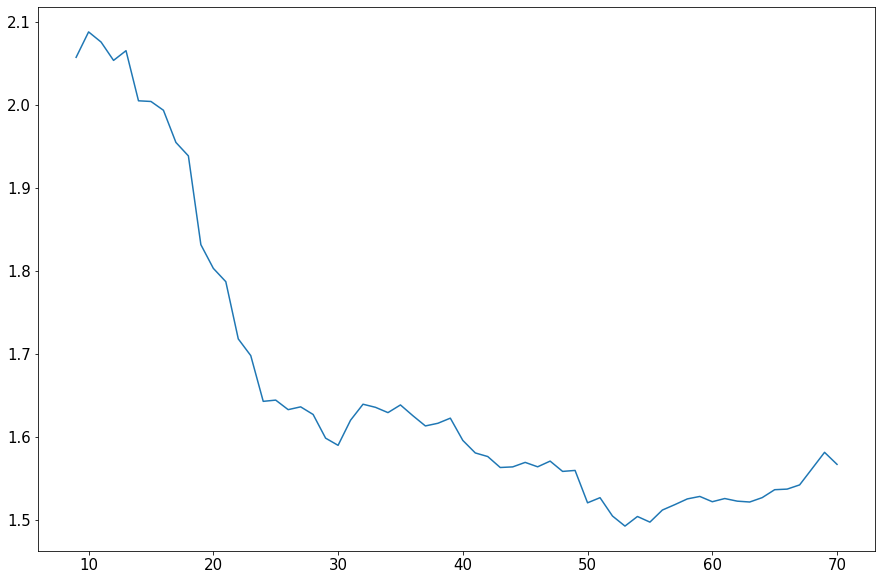

In [101]:
ax = plt.plot(output["MAE Trend"][9:70])
plt.show

In [102]:
k_best = output[output["MAE Trend"] == np.min(output["MAE Trend"][12:70])]
k_best

,k,MAE Trend,Improvement
53.0,53,1.49303,-99.0149


### 2.1.3. Run

In [103]:
start_date = '2005-01-01' 
end_date = '2020-10-01'
k = int(k_best.k)

start_date = datetime.strptime(start_date, '%Y-%m-%d')  
end_date = datetime.strptime(end_date, '%Y-%m-%d')

imp = []
base = []
trend = []
birth = []
maeTrend = []
    
for single_date in dateRange(start_date, end_date, k):
    date = single_date.strftime("%Y-%m-%d")
    dft, impt, mae_trendt = predictionCorr(date,k,birth_df,GTD_df,best[0:3].values) #Predicting    
    birth.append(dft['birth'][-1]) #Real data
    base.append(dft['predict_base'][-1]) #Base prediction
    trend.append(dft['predict_trend'][-1]) #Trend prediction 
    imp.append(impt) #improvement for the date

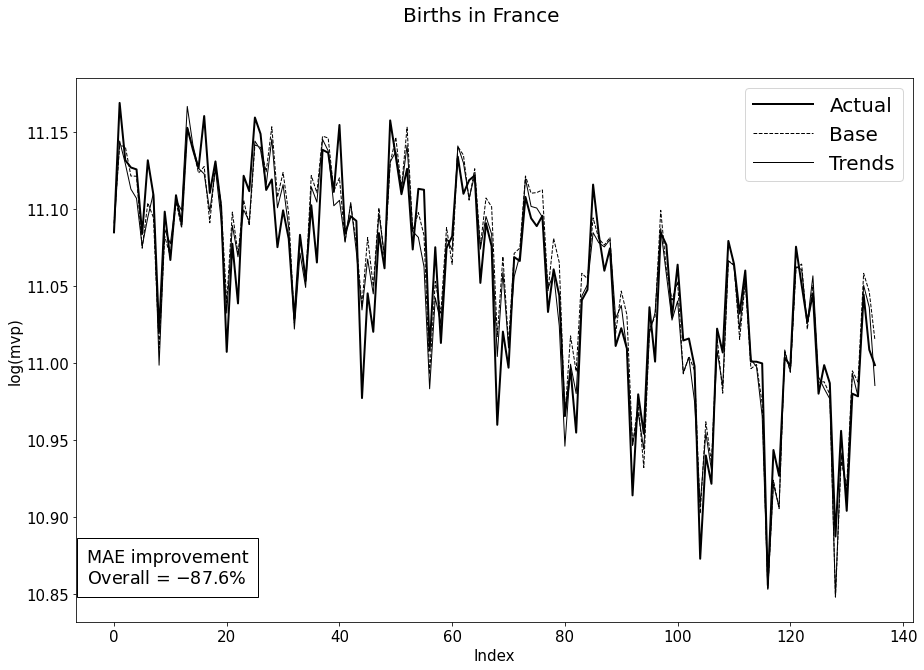

In [104]:
df = pd.DataFrame()
df["birth"]=birth
df["predict_base"]=base
df["predict_trend"]=trend
improvement_overall = np.mean(imp)

showPlot(df, improvement_overall)

## 2.2. By correlation with rolling window

### 2.2.1 Algorithm

In [ ]:
###### DON T RUN TAKES 5 HOURS #######

output = pd.DataFrame(index=np.linspace(0,210,211), columns=["k","MAE Base", "MAE Trend", "Improvement"])
for k in range (6,45):
    #Data for correlation
    start_date = '2005-01-01' 
    end_date = '2020-10-01'

    #for k in range (4,40)
    #Date processing
    start_date = datetime.strptime(start_date, '%Y-%m-%d')  
    end_date = datetime.strptime(end_date, '%Y-%m-%d')

    #output dataframe for the best parameters
    best = pd.DataFrame()

    #Loop in which we find the best hyper parameters with correlation
    for single_date in dateRange(start_date, end_date, k):
        date = single_date.strftime("%Y-%m-%d")
        corr = bestFeatureCorrelation(date, k)
        best[date]=corr.id[0:10]


    imp = []
    base = []
    trend = []
    birth = []
    maeBase = []
    maeTrend = []
    #Predicting the values for each date

    for single_date in dateRange(start_date, end_date, k):
        date = single_date.strftime("%Y-%m-%d")
        aze, impt, mae_baset, mae_trendt = prediction(date,k,birth_df,GTD_df,best[date][0:1]) #Predicting    
        birth.append(aze['birth'][-1]) #Real data
        base.append(aze['predict_base'][-1]) #Base prediction
        trend.append(aze['predict_trend'][-1]) #Trend prediction 
        imp.append(impt) #improvement for the date
        maeBase.append(mae_baset) #improvement for the date
        maeTrend.append(mae_trendt) #improvement for the date
    
    output.iloc[k] = [k,np.mean(maeBase), np.mean(maeTrend), np.mean(imp)]
    print("Run:", k, "|| MAE Base:", np.mean(maeBase), "|| MAE Trend:", np.mean(maeTrend), "|| Improvement:",np.mean(imp))

In [ ]:
output = output.dropna()
MaeTrend = output["MAE Trend"]

### 2.2.2. Parameter validation

In [105]:
MaeTrend = pd.DataFrame([8.081609884810343, 2.837861126900694, 2.065574462392271, 1.7862611522337535, 1.7042057333869982,
            1.84528428532989, 1.677494726762073, 1.7940966652070183, 1.7405841229851622, 1.6636901406360616,
            1.6991142141610194, 1.7541018276558975, 1.877600994069425, 2.004126810502877, 1.8337459019953573,
            1.7448858701141965, 1.8271773927381978, 1.7955265215814364, 1.7260588510921366, 1.6743005713791963,
            1.7249091776468428, 1.7060644918306502, 1.7411751146003709,1.7284818688144787, 1.6727550656583408,
            1.6535121808530175, 1.6271999944477737, 1.6348469310998994, 1.6486298696652602, 1.6585134552948295,
            1.6474716660718776, 1.6366504599673888, 1.6188135144448226, 1.668446798120343, 1.6605479652305233,
            1.6345435888604376])

In [107]:
k_best = (MaeTrend[MaeTrend == np.min(MaeTrend)].dropna())
k_best

,0
32,1.618814


### 2.2.3. Run

In [108]:
start_date = '2005-01-01' 
end_date = '2020-10-01'
k = k_best.index.astype(int)[0]

start_date = datetime.strptime(start_date, '%Y-%m-%d')  
end_date = datetime.strptime(end_date, '%Y-%m-%d')

imp = []
base = []
trend = []
birth = []
maeTrend = []
    
for single_date in dateRange(start_date, end_date, k):
    date = single_date.strftime("%Y-%m-%d")
    dft, impt, mae_trendt = predictionCorr(date,k,birth_df,GTD_df,best[0:1].values) #Predicting    
    birth.append(dft['birth'][-1]) #Real data
    base.append(dft['predict_base'][-1]) #Base prediction
    trend.append(dft['predict_trend'][-1]) #Trend prediction 
    imp.append(impt) #improvement for the date

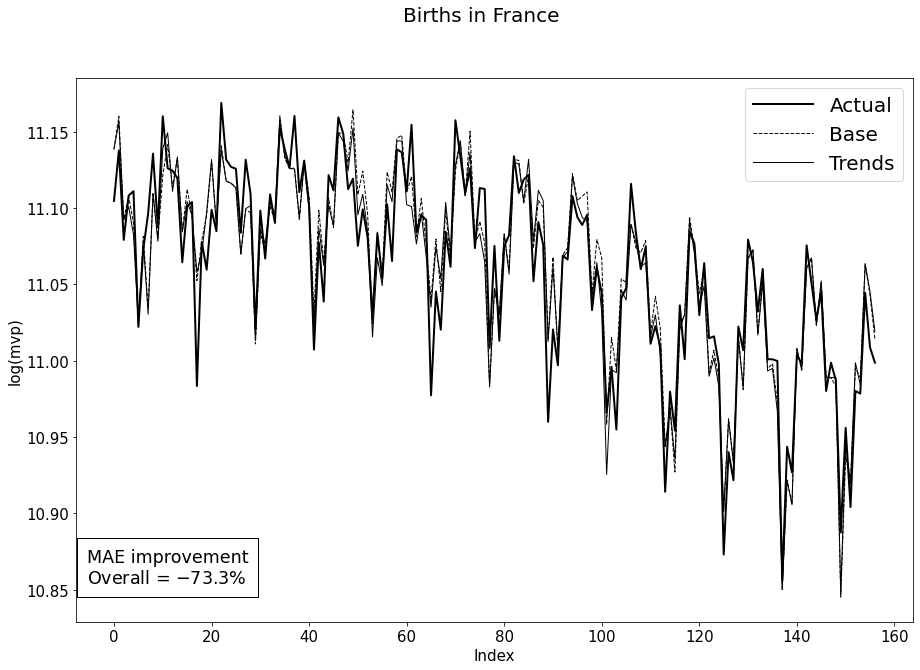

In [109]:
df = pd.DataFrame()
df["birth"]=birth
df["predict_base"]=base
df["predict_trend"]=trend
improvement_overall = np.mean(imp)

showPlot(df, improvement_overall)

## 2.3. By improvement overall

### 2.3.1. Algorithm

In [12]:
#function definition
def best_feature_improvement(k,start = '2004-01-01', end = '2020-10-01'):
    '''
    Input: 
        - k: rolling windiw size
        - start: start date in format '2004-01-01'
        - end: end date in format '2020-10-01'
    
    Output:
        - categories_best: A list of the categories ordered by improvement compared to the base model during the selected period
    '''

    # Keep track of all the mae
    mae = []
    
    # For each categories
    for i in GTD_df.columns:

        # Creating a new Dataframe
        df = birth_df.copy()
        
        # Selecting the correct period
        df = df.loc[start:end]
        temp_GTD_df = GTD_df.loc[start:end]
        # Setting up the category of interest
        df["y0"] = temp_GTD_df[i]
        df = df.reset_index(drop=True) #Resetting the index to [0-n] format

        # Trend model with the selected category
        res_trend = RollingOLS.from_formula('birth ~ birth_6 + birth_12 + y0', data=df, window=k).fit()# We use our rolling windows function
        params = pd.DataFrame(res_trend.params.shift(periods=1, axis=0)) # We shift the output parameters one row down in order to apply to the next mont (predict)
        params.columns = ['b0','b1','b2','b3']# Changing the parameters' columns names
        df = pd.concat([df, params], axis=1) # Adding it to our dataframe
        df['predict_trend'] = df.b0 + df.b1*df.birth_6 + df.b2*df.birth_12 + df.b3 * df.y0   # Predicting the values for the next month

        #Calculating MAE and Improvement
        mae_trends = np.mean(abs(df.birth-df.predict_trend))*100
        
        # Adding the improvement to our records
        mae.append(mae_trends)


    # Making a df with all the categories ordered correctly
    categories_best = categories_df.reset_index(drop=True)
    categories_best['mae'] = pd.DataFrame(mae)
    categories_best = categories_best.sort_values('mae', ascending=True)
    categories_best = categories_best.reset_index(drop=True)
    
    return categories_best

def make_date_best(best):
    '''
    From a list of best categories, create an dataframe containing the n'th best categories for each date
    
    Input:
        - best: Dataframe the categories ordered
    Output:
        - temp: a dataframe with the categories at each date
    '''
    # Creating a Dataframe with the correct dates
    temp = pd.DataFrame(index = birth_df.index)
    # For the number of best category we want
    for i in range (number_of_best_cat):
        # Add them at each date
        temp[str("id{}".format(best.index[i]))] = np.ones((len(birth_df),1)) * best.id[i]
        
    return temp

### 2.3.2. Parameter validation

There is no validation rolling window k. This paramters is already optimized for the smallest MAE for the base model. The point of this study is to improve the base model therefore the same k =24 will be used here.

In [13]:
best_cat =list(range(1,5))

improvement=[]
for number_of_best_cat in best_cat:
    best_id = best_feature_improvement(k)
    best_id = make_date_best(best_id)
    months_shift = k
    
    # Reset dataframes
    temp_df=pd.DataFrame(GTD_df, dtype='float')
    df = birth_df.copy()

    # Predict with these categories
    # Create empty prediction
    predict_base=[np.nan]*(months_shift+1)
    predict_trend=[np.nan]*(months_shift+1)
    # for each date
    for i in range(months_shift+1,len(birth_df)):
        # find current month
        j=birth_df.index[i]
        # find category corresponding to current month
        ids = best_id.loc[j,:]
        # Predict current value with current category
        pred = prediction(j -pd.DateOffset(months=months_shift),j,k,df,temp_df,ids)
        # Save prediction
        predict_base.append(pred['predict_base'][-1])
        predict_trend.append(pred['predict_trend'][-1])

    # Save predictions
    df['predict_base'] = predict_base
    df['predict_trend'] = predict_trend

    # Compute maes and improvement
    mae_base = np.mean(abs(df.birth-df.predict_base))*100
    mae_trends = np.mean(abs(df.birth-df.predict_trend))*100
    improvement_overall = (mae_base-mae_trends)*100 /mae_base

    # Save improvement for current number of categories
    improvement.append(improvement_overall)
    
Improvement = pd.DataFrame([improvement], columns=best_cat)
Improvement

,1,2,3,4
0,3.523319,2.281006,1.259027,0.532247


In [15]:
# Selecting the best number of categories
number_of_best_cat = best_cat[Improvement.values.argmax()]
number_of_best_cat

1

### 2.3.3. Run

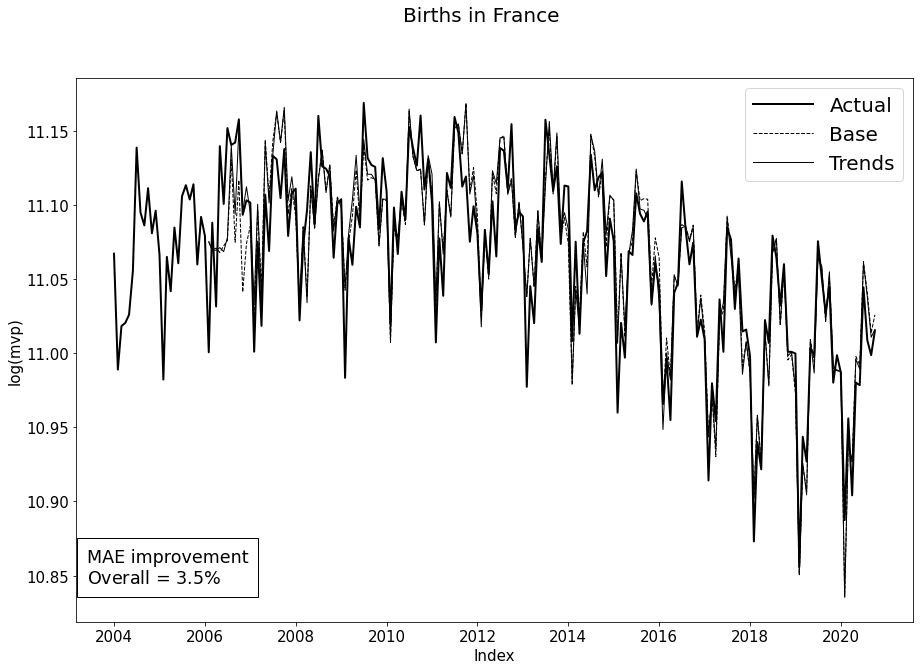

In [16]:
# find best feature overall
best_id = best_feature_improvement(k)

# Transforming the id into a date array for correct prediction
best_id = make_date_best(best_id)

# updating the months shift variable for later use
months_shift = k


# Reset dataframes
temp_df=pd.DataFrame(GTD_df, dtype='float')
df = birth_df.copy()

# Predict with these categories
# Create empty prediction
predict_base=[np.nan]*(months_shift+1)
predict_trend=[np.nan]*(months_shift+1)
# for each date
for i in range(months_shift+1,len(birth_df)):
    # find current month
    j=birth_df.index[i]
    # find category corresponding to current month
    ids = best_id.loc[j,:]
    # Predict current value with current category
    pred = prediction(j -pd.DateOffset(months=months_shift),j,k,df,temp_df,ids)
    # Save prediction
    predict_base.append(pred['predict_base'][-1])
    predict_trend.append(pred['predict_trend'][-1])

# Save predictions
df['predict_base'] = predict_base
df['predict_trend'] = predict_trend

# Compute maes and improvement
mae_base = np.mean(abs(df.birth-df.predict_base))*100
mae_trends = np.mean(abs(df.birth-df.predict_trend))*100
improvement_overall = (mae_base-mae_trends)*100 /mae_base

showPlot(df, improvement_overall)

## 2.4. By improvement with rolling window

### 2.4.1. Algorithm

In [17]:
#function definition
def best_feature_improvement_rolling(shift):
    '''
    Find the best categories on the past shift'th months. 
    Exemple: You want to find the best possible categories on july 2018 
                if shift = 1 you will look at the best categories to predict june 2018
                if shift = 3 you will look at the best categories to predict april,may and june 2018
             and output these categories for the month of july 2018.
    Input:
        - shift : the number of months you want to look back
    
    Output:
        - categories_best : the best categories for each month
    '''
    # The total number of month to include in our computation
    months_shift = k+shift
    
    # The output names of the columns if want to output multiple categories
    columns_name = []
    for i in range (number_of_best_cat):
        columns_name.append(str("id{}".format(i)))
    
    # Shift the date by 1 month and by months_shift month
    Date_shifted = birth_df.index.shift(-months_shift, freq ='MS') 
    Date_shifted_1 = birth_df.index.shift(-1, freq ='MS') 
    
    # Create dataframe for outputing values
    predict_gtd = pd.DataFrame(dtype='float')
    categories_best = pd.DataFrame()
    maes = pd.DataFrame()
    
    # For each month
    for i in range(months_shift,len(birth_df)):
        # Get correct time range
        start = Date_shifted[i]
        end = Date_shifted_1[i]
        
        # Find best categories for the current month
        categories_best_temp = best_feature_improvement(k,start,end)
        
        # Add it to our df
        predict_gtd = predict_gtd.append(categories_best_temp.id[0:number_of_best_cat].transpose())
        categories_best = categories_best.append(categories_best_temp.name[0:number_of_best_cat].transpose())
        maes = maes.append(categories_best_temp.mae[0:number_of_best_cat].transpose())
        
        # Print the date we just found
        #print(birth_df.index[i])
        
    
    # Create dataframe with correct indices and columns name
    # With categories ids
    predict_gtd.index = birth_df.index[months_shift:]
    predict_gtd.columns = columns_name
    # With categories name and improvement
    categories_best.index = birth_df.index[months_shift:]
    maes.index = birth_df.index[months_shift:]
    categories_best = pd.merge(categories_best,maes,left_index = True,right_index = True)
    
    return predict_gtd,categories_best

### 2.4.2. Parameter validation

In [ ]:
# Array of possible number for best categories
best_cat = [1,2,3,4]
# Array of possible number for best shifting
shift = [1,2,3,5,7]

# Array to save all the improvements
Improvement =[]
# For each shift number
for shifting in shift:
    # Array to save all the improvement for a certain number of category
    improvemnt_temp = []
    # For each category number
    for number_of_best_cat in best_cat:
        
        # Update the month shift variable
        months_shift = k+shifting
        
        # Find best categories
        [best_id,best] = best_feature_improvement_rolling(shifting)

        # Reset dataframes
        temp_df=pd.DataFrame(GTD_df, dtype='float')
        df = birth_df.copy()

        # Predict with these categories
        # Create empty prediction
        predict_base=[np.nan]*(months_shift+1)
        predict_trend=[np.nan]*(months_shift+1)
        # for each date
        for i in range(months_shift+1,len(birth_df)):
            # find current month
            j=birth_df.index[i]
            # find category corresponding to current month
            ids = best_id.loc[j,:]
            # Predict current value with current category
            pred = prediction(j -pd.DateOffset(months=months_shift),j,k,df,temp_df,ids)
            # Save prediction
            predict_base.append(pred['predict_base'][-1])
            predict_trend.append(pred['predict_trend'][-1])

        # Save predictions
        df['predict_base'] = predict_base
        df['predict_trend'] = predict_trend

        # Compute maes and improvement
        mae_base = np.mean(abs(df.birth-df.predict_base))*100
        mae_trends = np.mean(abs(df.birth-df.predict_trend))*100
        improvement_overall = (mae_base-mae_trends)*100 /mae_base
        
        # Save improvement for current number of categories
        improvemnt_temp.append(improvement_overall)
    # Save improvement for current shift number
    Improvement.append(improvemnt_temp)
    
# Make a nice dataframe
Improvement = pd.DataFrame(Improvement, columns=best_cat, index = shift)
# Overview to find the best parameters
Improvement

As the previous cell is very long to run the results were found previously and are creating in next cells

In [22]:
# Array of possible number for best categories
best_cat = [1,2,3,4]
# Array of possible number for best shifting
shift = [1,2,3,5,7]

Improvement = [[-2.67,-9.31548,-17.82793,-999],[-6.13288,-4.62006,-18.41623,-999],[-4.61616,-6.75310,-8.86258,-999],[-12.8655,-8.385916,-14.74858,-999],[-8.33343,-11.613032,-11.25305,-999]]

# Make a nice dataframe
Improvement = pd.DataFrame(Improvement, columns=best_cat, index = shift)
# Overview to find the best parameters
Improvement

,1,2,3,4
1,-2.67000,-9.315480,-17.82793,-999
2,-6.13288,-4.620060,-18.41623,-999
3,-4.61616,-6.753100,-8.86258,-999
5,-12.86550,-8.385916,-14.74858,-999
7,-8.33343,-11.613032,-11.25305,-999


In [23]:
idx = np.unravel_index(np.argmax(Improvement.values, axis=None), Improvement.values.shape)
# Selecting the best number of category
number_of_best_cat = best_cat[idx[1]]
# Selecting the best shift value
shift = shift[idx[0]]
# Updating month shift variable
months_shift = k+shift

print('number_of_best_cat = %d; shift= %d' % (number_of_best_cat,shift))

number_of_best_cat = 1; shift= 1


### 2.4.3. Run

In [ ]:
# Finding the best results
[best_id,best] = best_feature_improvement_rolling(shift)

# Reset dataframes
temp_df=pd.DataFrame(GTD_df, dtype='float')
df = birth_df.copy()

# Predict with these categories
# Create empty prediction
predict_base=[np.nan]*(months_shift+1)
predict_trend=[np.nan]*(months_shift+1)
# for each date
for i in range(months_shift+1,len(birth_df)):
    # find current month
    j=birth_df.index[i]
    # find category corresponding to current month
    ids = best_id.loc[j,:]
    # Predict current value with current category
    pred = prediction(j -pd.DateOffset(months=months_shift),j,k,df,temp_df,ids)
    # Save prediction
    predict_base.append(pred['predict_base'][-1])
    predict_trend.append(pred['predict_trend'][-1])

# Save predictions
df['predict_base'] = predict_base
df['predict_trend'] = predict_trend

# Compute maes and improvement
mae_base = np.mean(abs(df.birth-df.predict_base))*100
mae_trends = np.mean(abs(df.birth-df.predict_trend))*100
improvement_overall = (mae_base-mae_trends)*100 /mae_base

# Plotting the results
showPlot(df, improvement_overall)

## 2.5. Final Algorithm selection

### 2.5.1. Selection

### 2.5.2. Final category selection

# 3. Prediction and visualization

## 3.1 Prediction

## 3.2 Prediction plotting

In [ ]:
temp_df=pd.DataFrame(GTD_df, dtype='float')
df = birth_df.copy()

predict_base=[np.nan]*(months_shift+1)
predict_trend=[np.nan]*(months_shift+1)


for i in range(months_shift+1,len(birth_df)):
    j=birth_df.index[i]
    ids = best_id.loc[j,:]
    pred = prediction(j -pd.DateOffset(months=months_shift),j,k,df,temp_df,ids)
    predict_base.append(pred['predict_base'][-1])
    predict_trend.append(pred['predict_trend'][-1])

df['predict_base'] = predict_base
df['predict_trend'] = predict_trend

mae_base = np.mean(abs(df.birth-df.predict_base))*100
mae_trends = np.mean(abs(df.birth-df.predict_trend))*100
improvement_overall = (mae_base-mae_trends)*100 /mae_base

showPlot(df, improvement_overall)

## 3.3 Visualisation of categories

In [ ]:
def CountFrequency(my_list): 
  
    # Creating an empty dictionary  
    freq = {} 
    for item in my_list: 
        if (item in freq): 
            freq[item] += 1
        else: 
            freq[item] = 1
    
    return freq